# Sweeps Quickstart

从任何机器学习模型开始，并在几分钟内运行 parallel hyperparameter sweep。

## 1. Set up `wandb`

### Set up your account

- 从W&B帐户开始。
- 转到终端中的项目文件夹并安装库： `pip install wandb`
- 在项目文件夹中，登录 W&B ： `wandb login`

### Set up your Python training script

- 导入我们的库 `wandb`
- 将超参数值传递给 `wandb.init` 以populate `wandb.config`。
- 使用配置中的值来构建模型并执行训练。
- 记录指标，以便在实时 dashboard 中查看它们。

请参阅下面的代码片段，了解设置超参数值的几种方法，以便训练脚本可以独立运行或作为 sweep 的一部分。

**Commandl line Arguments**

```python
import argparse
import wandb

# Build your ArgumentParser however you like
parser = setup_parser()

# Get the hyperparameters
args = parser.parse_args()

# Pass them to wandb.init
wandb.init(config=args)
# Access all hyperparameter values through wandb.config
config = wandb.config

# Set up your model
model = make_model(config)

# Log metrics inside your training loop
for epoch in range(config["epochs"]):
    val_acc, val_loss = model.fit()
    metrics = {"validation_accuracy": val_acc,
               "validation_loss": val_loss}
    wandb.log(metrics)
```

**In-line Dictionary**

```python
import wandb

# Set up your default hyperparameters
hyperparameter_defaults = dict(
    channels=[16, 32],
    batch_size=100,
    learning_rate=0.001,
    optimizer="adam",
    epochs=2,
    )

# Pass your defaults to wandb.init
wandb.init(config=hyperparameter_defaults)
# Access all hyperparameter values through wandb.config
config = wandb.config

# Set up your model
model = make_model(config)

# Log metrics inside your training loop
for epoch in range(config["epochs"]):
    val_acc, val_loss = model.fit()
    metrics = {"validation_accuracy": val_acc,
               "validation_loss": val_loss}
    wandb.log(metrics)
```

**config.py File**

```python
import wandb

import config  # python file with default hyperparameters

# Set up your default hyperparameters
hyperparameters = config.config

# Pass them wandb.init
wandb.init(config=hyperparameters)
# Access all hyperparameter values through wandb.config
config = wandb.config

# Set up your model
model = make_model(config)

# Log metrics inside your training loop
for epoch in range(config["epochs"]):
    val_acc, val_loss = model.fit()
    metrics = {"validation_accuracy": val_acc,
               "validation_loss": val_loss}
    wandb.log(metrics)
```

## 2. Configure your sweep

设置一个 YAML 文件来指定您想要 sweep 的超参数，以及 sweep 的结构，如要调用的训练脚本、搜索策略和停止使用的标准等。

以下是一些关于配置 sweep 的资源:
- **Example YAML files**: 一个示例脚本和几个不同的YAML文件
- **Configuration**: 设置 sweep 配置的完整规格
- - top-level 配置，例如您的 `wandb` 帐户的 `entity` 或 `project`
- - low-level 配置，如 sweep 程序的命令行参数
- **Jupyter Notebook**: 使用Python字典而不是YAML文件设置扫描配置
- **Generate config from UI**: 取一个现有的W&B项目并生成一个配置文件
- **Feed in prior runs**: 进行之前的运行，并将其添加到新的 sweep 中

这里有一个名为 `sweep.yaml` 的 sweep 配置文件示例：

```yaml
program: train.py
method: bayes
metric:
  name: validation_loss
  goal: minimize
parameters:
  learning_rate:
    min: 0.0001
    max: 0.1
  optimizer:
    values: ["adam", "sgd"]
```

> 如果您指定了一个要优化的指标，请确保您正在记录它。在本例中，我的配置文件中有 `validation_loss`，因此我必须在脚本中记录确切的 metric 名称：
```
wandb.log({"validation_loss": val_loss})
```

> 如果您想优化多个指标，请考虑使用 weighted optimization metric。

此示例配置将使用贝叶斯搜索方法来选择一组超参数值，作为命令行参数传递给 `train.py` 脚本。在调用`wandb.init` 后，也可以通过 `wandb.config` 访问超参数。

> 如果您在脚本中使用 `argparse`，我们建议您在变量名中使用下划线而不是连字符。

## 3. Initialize a sweep

在 `sweep.yaml` 上设置了 sweep 配置文件后，运行以下命令开始：

```
wandb sweep sweep.yaml
```

此命令将打印一个 *sweep ID*，其中包括 entity 名称和 project 名称。复制它以在下一步中使用！

## 4. Launch agent(s)

在您想要为 sweep 做出贡献的每台机器或每个流程中，启动一个 “agent”。每个 agent 都将轮询您使用 `wandb sweep` 启动的 `central W&B sweep server`，以便运行下一组超参数。您需要对参与同一 sweep 的所有 agent 使用相同的 sweep ID。

在您自己的机器上的shell中，运行 `wandb agent` 命令：

```
wandb agent <USERNAME/PROJECTNAME/SWEEPID>
```

## 5. Visualize results

打开 project，在 sweep dashboard 中查看您的实时结果。只需点击几下，即可构建丰富的交互式图表，如并行坐标图、参数重要性分析等。

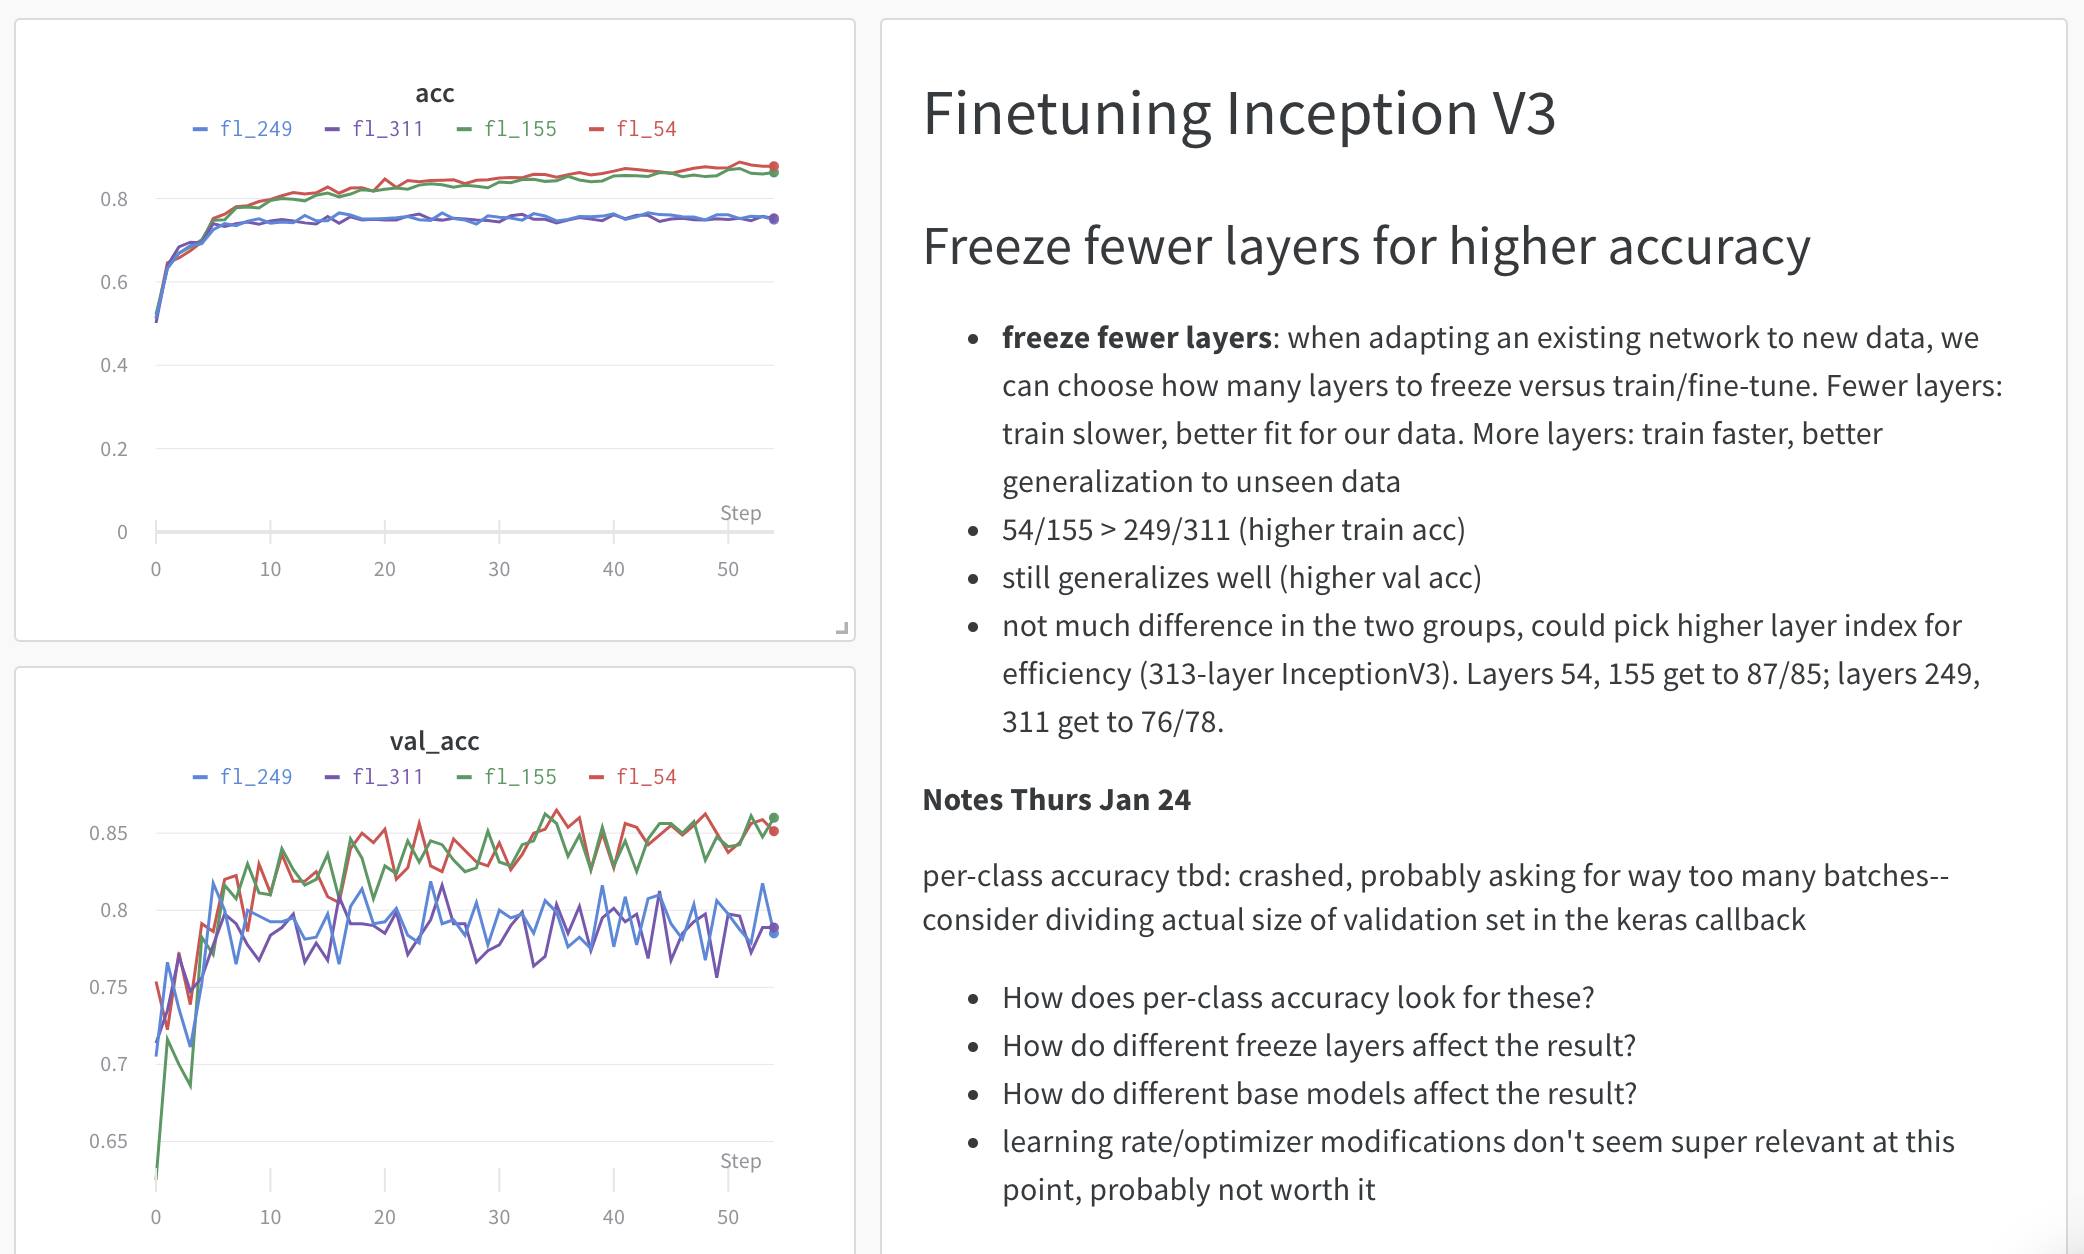

## 6. Stop the agent

从终端，点击 `Ctrl+c` 以停止 sweep agent 当前正在运行的运行。要杀死 agent，请在运行停止后再次点击 `Ctrl+c`。